In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.image import imread
from collections import Counter
import seaborn as sns
from PIL import Image
from io import BytesIO
from scipy import ndimage
import cv2
import itertools
from sklearn.cluster import DBSCAN
import torch
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

In [90]:
def get_file_data(file_name):

    test_image = os.path.join('C:/Users/snack/Desktop/SEAM/VOC2012_data/JPEGImages/', file_name + '.jpg')
    sample_zero_image = cv2.imread(test_image)

    image_crf_npy = os.path.join('C:/Users/snack/Desktop/SEAM/voc12/out_crf_4.0', file_name + '.npy')
    sample_npy_data = np.load(image_crf_npy, allow_pickle=True).item()

    #image_cam_npy = os.path.join('C:/Users/snack/Desktop/SEAM/voc12/out_cam', file_name + '.npy')
    #sample_npy_data = np.load(image_cam_npy, allow_pickle=True).item()
    
    return sample_zero_image, sample_npy_data


def sobel_filter(image_npy):
    dx = ndimage.sobel(image_npy[0], axis=0)
    dy = ndimage.sobel(image_npy[0], axis=1)
    sobel_filtered_image = np.hypot(dx, dy)  # Equivalent to sqrt(dx^2 + dy^2)

    sobel_filtered_image = sobel_filtered_image / np.max(sobel_filtered_image)
    return sobel_filtered_image


def remove_outliers(points_array):
    data_array = np.array(points_array)
    mean = np.mean(data_array, axis=0)
    std_dev = np.std(data_array, axis=0)
    
    std_dev[std_dev == 0] = 1e-6 
    std_dev[np.isnan(std_dev)] = 1e-6
    
    threshold = 1.8
    z_scores = np.abs((data_array - mean) / std_dev)
    filtered_data = data_array[(z_scores < threshold).all(axis=1)]
    
    return filtered_data


def depth_anything(file_name):
    file_path = os.path.join('C:/Users/snack/Desktop/SEAM/VOC2012_data/JPEGImages/', file_name + '.jpg')
    sample_image= Image.open(file_path)

    image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
    model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

    # prepare image for the model
    inputs = image_processor(images=sample_image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth

    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=sample_image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # visualize the prediction
    output = prediction.squeeze().cpu().numpy()
    #formatted = (output * 255 / np.max(output)).astype("uint8")
    #depth = Image.fromarray(formatted)
    
    return output


def pointSelection(cam_threshold, sobel_threshold, sample_npy_data, sobel_filtered_image, file_name):
    
    depth = depth_anything(file_name)
    
    boundary_points = []

    points_of_interest = np.where((sample_npy_data[0] >= cam_threshold))
    filtered_points_of_interest = remove_outliers(points_of_interest)   

    for point in zip(*filtered_points_of_interest):
        x, y = point

        sobel_value = sobel_filtered_image[x, y]
        
        if (sobel_value > sobel_threshold):
            
            boundary_points.append((y, x))

    boundary_points = remove_outliers(boundary_points)
    boundary_points_array = np.array(boundary_points)

    # Apply DBSCAN clustering
    eps = 10  # Adjust as needed, represents the maximum distance between two samples for them to be considered as in the same neighborhood
    min_samples = 5  # Adjust as needed, represents the number of samples in a neighborhood for a point to be considered as a core point
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(boundary_points_array)

    # Select one point from each cluster
    unique_labels = np.unique(cluster_labels)
    selected_points = []
    for label in unique_labels:
        cluster_points = boundary_points_array[cluster_labels == label]
        
        if len(cluster_points) > 0:
            # Select the point closest to the centroid of the cluster
            centroid = np.mean(cluster_points, axis=0)
            closest_point_idx = np.argmin(np.linalg.norm(cluster_points - centroid, axis=1))
            selected_point = cluster_points[closest_point_idx]
        
            if depth[int(selected_point[1]), int(selected_point[0])] != 0:
                selected_points.append(selected_point)

    # Convert the selected points to array
    selected_points_array = np.array(selected_points)

    # Save the selected points to a new file
    output_file_path = os.path.join('C:/Users/snack/Desktop/CAM4SAM/temp_files/points_of_interest.txt')
    np.savetxt(output_file_path, selected_points_array, fmt='%d', delimiter=',')
    return output_file_path

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   


def set_up_SAM():
    sam_checkpoint = "C:/Users/snack/Desktop/segment-anything/sam_vit_h_4b8939.pth"
    model_type = "vit_h"

    device = "cuda"

    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)

    predictor = SamPredictor(sam)
    return predictor


def sam_process_image(sam_predictor, test_image):
    image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    sam_predictor.set_image(image)


def get_input(pointAnnoFile):
    input_points = np.loadtxt(pointAnnoFile, delimiter=',')
    if input_points.ndim == 1:
        input_points = input_points.reshape((1, -1))

    num_points = len(input_points)
    input_labels = np.ones(num_points, dtype=int)
    for i, point in enumerate(input_points):
        input_labels[i] = 1

    return input_points, input_labels


def run_sam(sam_predictor, input_points, input_labels):
    masks, scores , logits = sam_predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True, 
    )

    return masks, scores , logits


def getIou(sam_masks, file_name):

    gt_mask = cv2.imread(os.path.join('C:/Users/snack/Desktop/SEAM/VOC2012_data/SegmentationClass/', file_name + '.png'), cv2.IMREAD_GRAYSCALE)
    predicted_mask = sam_masks

    # Convert masks to boolean arrays
    gt_mask_bool = gt_mask > 0
    predicted_mask_bool = predicted_mask > 0

    # Calculate intersection and union
    intersection = np.logical_and(gt_mask_bool, predicted_mask_bool)
    union = np.logical_or(gt_mask_bool, predicted_mask_bool)

    # Compute IoU
    iou = np.sum(intersection) / np.sum(union)
    print(iou*100)
    
    return iou*100

In [4]:
def experiment(thresholds, sample_image, sample_image_npy, sobel_filtered_image):

    top_10_results = []
    top_10_thresholds = []

    for cam_threshold, sobel_threshold in itertools.product(thresholds['cam'], thresholds['sobel']):
        try:
            print(cam_threshold, sobel_threshold)
            pointAnno = pointSelection(cam_threshold, sobel_threshold, sample_image_npy, sobel_filtered_image)
            sam_predictor = set_up_SAM()
            sam_process_image(sam_predictor, sample_image)
            input_points, input_labels = get_input(pointAnno)
            masks, scores , logits = run_sam(sam_predictor, input_points, input_labels)
            best_mask_index = np.argmax(scores)
            best_mask = masks[best_mask_index]
            iou_result = getIou(best_mask, file_name)

            try:
                plt.figure(figsize=(10, 10))
                plt.imshow(sample_image)
                show_mask(best_mask, plt.gca())
                show_points(input_points, input_labels, plt.gca())
                plt.axis('off')
                saving_file_name = file_name + '_' +  str(iou_result) + '_' + str(cam_threshold) + '_' + str(sobel_threshold) + '_' + '_heatmap.png'
                output_file = 'C:/Users/snack/Desktop/CAM4SAM/temp_files/best_masks/' + saving_file_name 
                plt.savefig(output_file, dpi=300)
            except Exception as e:
                print(f"Error occurred while saving best masked image")

            top_10_results.append(iou_result)
            top_10_thresholds.append((cam_threshold, sobel_threshold))
        except Exception as e:
            print(f"Error occurred for thresholds ({cam_threshold}, {sobel_threshold}): {e}")
            continue

    sorted_indices = sorted(range(len(top_10_results)), key=lambda i: top_10_results[i], reverse=True)
    sorted_top_10_results = [top_10_results[i] for i in sorted_indices]
    sorted_top_10_thresholds = [top_10_thresholds[i] for i in sorted_indices]

    #top_10_results = sorted_top_10_results[:10]
    #top_10_thresholds = sorted_top_10_thresholds[:10]
    top_10_results = sorted_top_10_results
    top_10_thresholds = sorted_top_10_thresholds

    try:
        cam_thresholds, sobel_thresholds = zip(*top_10_thresholds)
        iou_results = top_10_results

        bins = [np.linspace(0, 1, 21), np.linspace(0, 1, 21)]
        hist, xedges, yedges = np.histogram2d(cam_thresholds, sobel_thresholds, bins=bins, weights=iou_results)

        # Plot the heatmap
        plt.figure(figsize=(10, 8))
        plt.imshow(hist.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='viridis')
        plt.colorbar(label='IOU Result')
        plt.xlabel('CAM Threshold')
        plt.ylabel('Sobel Threshold')
        plt.title('IOU Result vs. Threshold Combinations')

        # Save the heatmap as an image
        output_file = 'C:/Users/snack/Desktop/CAM4SAM/temp_files/heatmap/' + file_name + '_heatmap.png'
        plt.savefig(output_file, dpi=300)
        #plt.show()
    except Exception as e:
        print(f"Error occurred while saving heatmap")

    return top_10_results, top_10_thresholds

In [5]:
#iterate through files in classZeroSinglesImages and run CAM4SAM
'''
output_directory = 'C:/Users/snack/Desktop/CAM4SAM/temp_files/'

thresholds = {
        'cam': [i / 100 for i in range(1, 41, 20)], 
        'sobel': [i / 100 for i in range(70, 89, 10)] 
        }

with open("C:/Users/snack/Desktop/CAM4SAM/temp_files/classZeroSingleInstanceImages.txt", "r") as file:
    for line in tqdm(file):
        line = line.strip()
        file_name = line.replace(".npy", "")

        print(file_name)
        sys.stdout.flush() 

        sample_image, sample_image_npy = get_file_data(file_name)
        sobel_filtered_image = sobel_filter(sample_image_npy)

        top_10_results, top_10_thresholds = experiment(thresholds, sample_image, sample_image_npy, sobel_filtered_image)
        output_file = 'C:/Users/snack/Desktop/CAM4SAM/temp_files/top_10_results/' + file_name + '_top_10_results.txt'
        with open(output_file, "w") as f:
            for i, (iou, threshold) in enumerate(zip(top_10_results, top_10_thresholds)):
                line = f"Top {i+1}: IOU = {iou}, threshold = {threshold}\n"
                f.write(line)
'''

'\noutput_directory = \'C:/Users/snack/Desktop/CAM4SAM/temp_files/\'\n\nthresholds = {\n        \'cam\': [i / 100 for i in range(1, 41, 20)], \n        \'sobel\': [i / 100 for i in range(70, 89, 10)] \n        }\n\nwith open("C:/Users/snack/Desktop/CAM4SAM/temp_files/classZeroSingleInstanceImages.txt", "r") as file:\n    for line in tqdm(file):\n        line = line.strip()\n        file_name = line.replace(".npy", "")\n\n        print(file_name)\n        sys.stdout.flush() \n\n        sample_image, sample_image_npy = get_file_data(file_name)\n        sobel_filtered_image = sobel_filter(sample_image_npy)\n\n        top_10_results, top_10_thresholds = experiment(thresholds, sample_image, sample_image_npy, sobel_filtered_image)\n        output_file = \'C:/Users/snack/Desktop/CAM4SAM/temp_files/top_10_results/\' + file_name + \'_top_10_results.txt\'\n        with open(output_file, "w") as f:\n            for i, (iou, threshold) in enumerate(zip(top_10_results, top_10_thresholds)):\n       

70.54948685650567


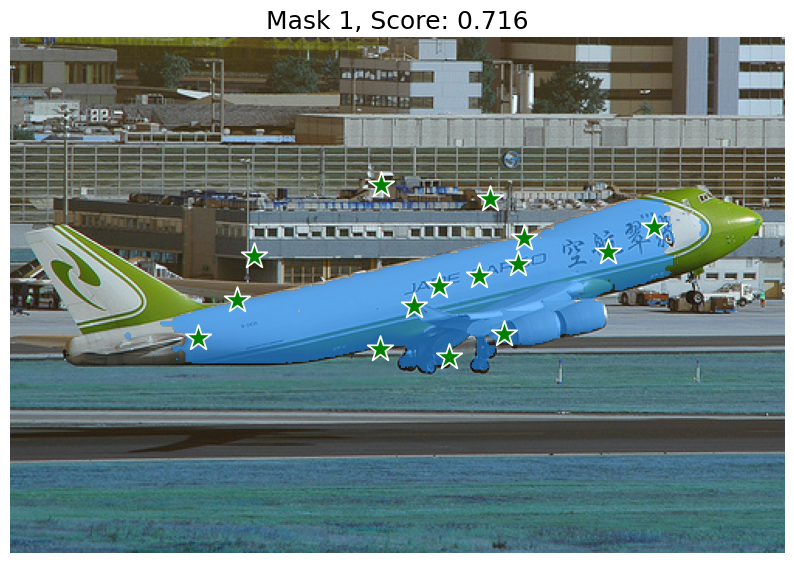

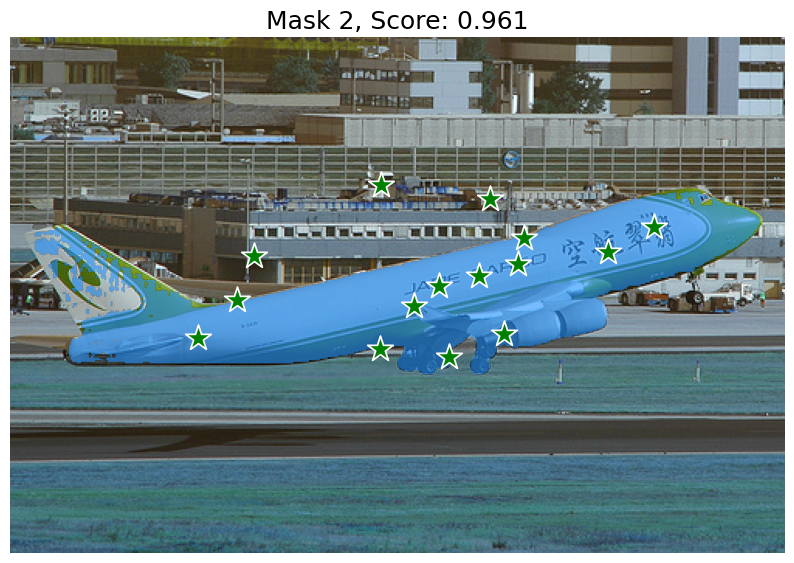

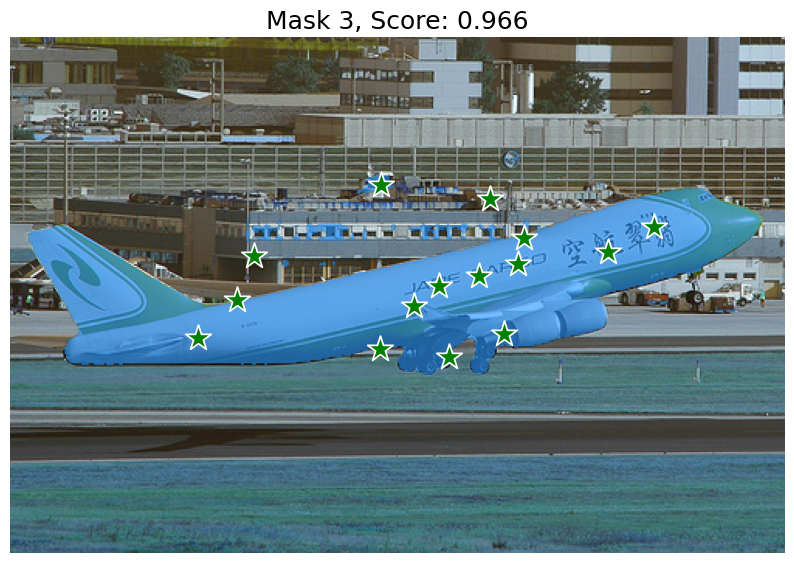

In [95]:
# testing on one image

file_name="2008_002358"
sample_image, sample_image_npy = get_file_data(file_name)
sobel_filtered_image = sobel_filter(sample_image_npy)
pointAnno = pointSelection(0.2, 0.8, sample_image_npy, sobel_filtered_image, file_name)
#pointAnno="C:/Users/snack/Desktop/CAM4SAM/temp_files/points_of_interest.txt"
sam_predictor = set_up_SAM()
sam_process_image(sam_predictor, sample_image)
input_points, input_labels = get_input(pointAnno)
masks, scores , logits = run_sam(sam_predictor, input_points, input_labels)
iou_result = getIou(masks, file_name)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(sample_image)
    show_mask(mask, plt.gca())
    show_points(input_points, input_labels, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [7]:
# trying Depth Anything

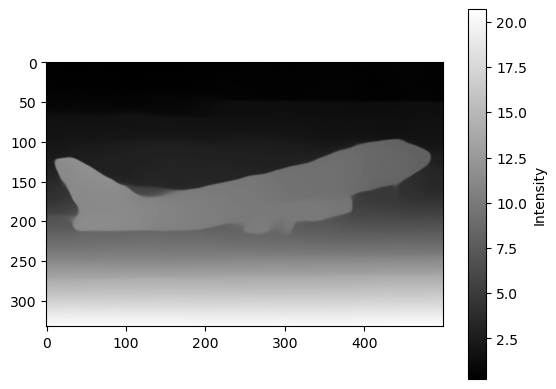

In [78]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests

file_name="2008_002358"
_, sample_image_npy = get_file_data(file_name)
sobel_filtered_image = sobel_filter(sample_image_npy)
file_path = os.path.join('C:/Users/snack/Desktop/SEAM/VOC2012_data/JPEGImages/', file_name + '.jpg')
sample_image= Image.open(file_path)

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

# prepare image for the model
inputs = image_processor(images=sample_image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=sample_image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)


plt.imshow(output, cmap='gray')
plt.colorbar(label='Intensity')
plt.show()

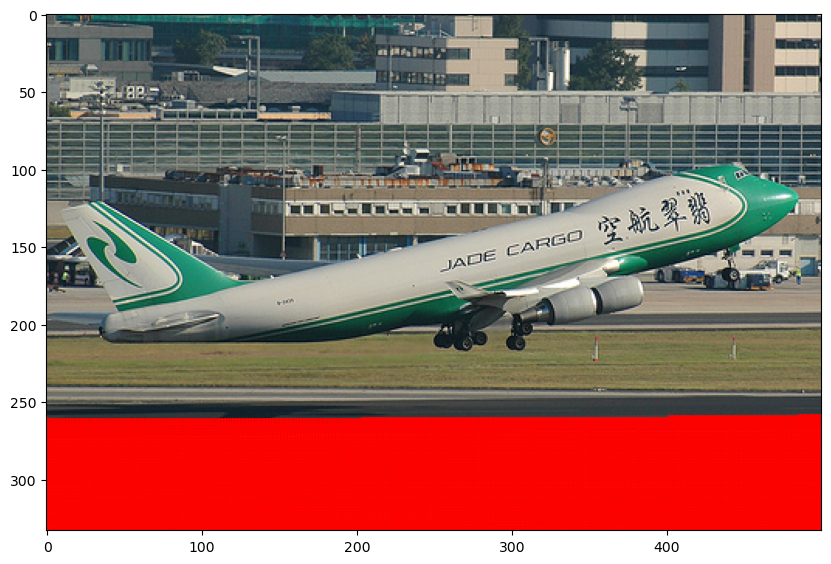

In [79]:
original_image_array = np.array(sample_image)

# Condition for filtering
condition = (sobel_filtered_image > 0.0) & (formatted > 150)

# Get the indices where condition is True
y_indices, x_indices = np.where(condition)

# Plotting
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
plt.imshow(original_image_array, cmap='gray')  # or remove cmap='gray' if the original image is in color

# Scatter plot on the image
plt.scatter(x_indices, y_indices, color='red', s=1)  # Adjust color and size as needed

plt.show()

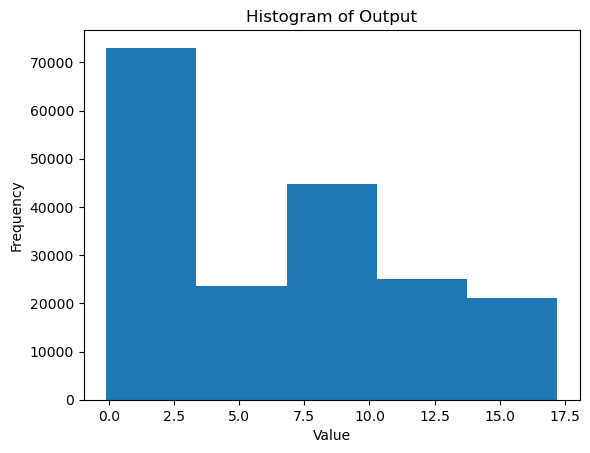

In [27]:
plt.hist(output.flatten(), bins=5)  # You can adjust the number of bins
plt.title("Histogram of Output")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

Plotting Values: 255it [00:00, 980.19it/s] 


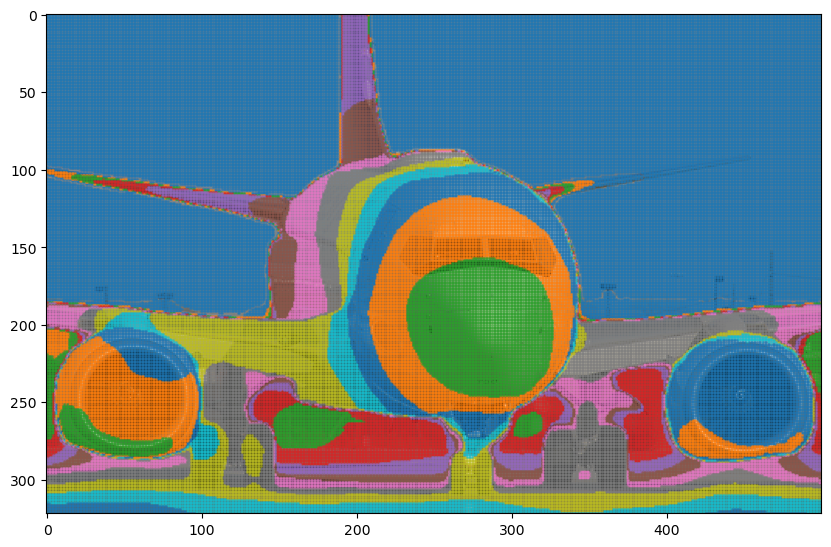

In [69]:
hist, bins = np.histogram(formatted, bins=255)

# Plotting setup
fig, ax = plt.subplots(figsize=(10, 10))
image_plot = ax.imshow(original_image_array, cmap='gray')  # Remove 'cmap' if your original image is in color

# Iterate over each bin
for i, bin_start in tqdm(enumerate(bins[:-1]), desc='Plotting Values'):
    bin_end = bins[i + 1]
    # Find the indices where 'output' falls within the current bin
    indices_in_bin = np.where((output >= bin_start) & (output < bin_end))
    y_indices = indices_in_bin[0]
    x_indices = indices_in_bin[1]
    
    # Scatter plot on the image
    ax.scatter(x_indices, y_indices, s=1, alpha=0.5)  # Adjust size and transparency as needed

plt.show()

In [12]:
# trying Grounding Dino